In [1]:
import pysb
import getpass

In [2]:
username = '{}@usgs.gov'.format(getpass.getuser())
password = getpass.getpass()

print('username: ', username)

········
username:  talbertc@usgs.gov


In [3]:
sb = pysb.SbSession()
sb.login(username, password)

In [74]:
sb_num = '58bd9576e4b01a6517dc0cfd'

## As pysb stands now:

In [75]:
sb_item = sb.get_item(sb_num)
print(sb_item)

{'browseTypes': ['Downloadable', 'Map Service', 'OGC WMS Service', 'OGC WFS Layer', 'OGC WMS Layer'], 'webLinks': [{'type': 'webLink', 'hidden': False, 'title': "Kansas Department of Agriculture's Division of Water Resources (DWR) Water Use Reporting webpage", 'typeLabel': 'Web Link', 'uri': 'https://agriculture.ks.gov/divisions-programs/dwr/water-appropriation/water-use-reporting', 'rel': 'related'}, {'type': 'webLink', 'hidden': False, 'title': 'Kansas Water Office (KWO) reservoir accounting information webpage.', 'typeLabel': 'Web Link', 'uri': 'http://www.kwo.org/Reservoirs.html#Reservoir Accounting', 'rel': 'related'}, {'type': 'webLink', 'hidden': False, 'title': 'State of Kansas Regional Advisory webpage.', 'typeLabel': 'Web Link', 'uri': 'http://www.kwo.org/Regional-Advisory-Committees.html', 'rel': 'related'}, {'type': 'webapp', 'hidden': False, 'title': 'WIMAS is a web based application that allows users to query, analyze, and map Kansas water right data.', 'typeLabel': 'Web 

### get the csv and convert it to a dataframe

It's not the end of the world, but it's not easy or intuitive

Does sb.get_item_file_info take the id or the full json?
I've got to write a list comprehension with an if, or worse a loop

In [84]:
this_item_files = sb.get_item_file_info(sb_item)
csvs = [file for file in this_item_files if file['name'].endswith('.csv')]
url = csvs[0]['url']
data = pd.read_csv(url, skiprows=7, encoding = "ISO-8859-1")
data.head()

,GPCD Region,Average gpcd 2011,Average gpcd 2012,Average gpcd 2013,Average gpcd 2014,Average gpcd 2015,Average gpcd 201115
0,1,282,316,280,264,236,276
1,2,237,261,227,218,199,228
2,3,229,256,217,210,200,222
3,4,196,199,175,154,147,174
4,5,149,149,126,116,114,131


In [41]:
sb_item['title'] = '...'

# sb.update_item(sb_item)

{'name': 'GermaineEtAlData.csv',
 'size': 62351,
 'url': 'https://www.sciencebase.gov/catalog/file/get/58b47029e4b01ccd54fca8a9?f=__disk__18%2F0a%2F9e%2F180a9e5046ee2257647a7e8082a5a5e8acb9454d'}

## My suggestion

In [115]:
import pandas as pd

class SBItem(object):
    def __init__(self, item, recursive=False):
        #add code so item could be 'json', 'sb hashtag', 'doi', or ???
        #TODO: add recursive code to generate child objects on load of the parent
        
        if type(item) == dict:
            self.json = item
        else:
            self.json = sb.get_item(item)
        
        #all of the keys in our json become methods on our object
        for key in self.json.keys():
            self.__dict__[key] = self.json[key]
           
        #this could be fleshed out a bit
        if self.hasChildren:
            self.children_ids = sb.get_child_ids(self.id)
        else:
            self.children_ids = []
            
        self._files_info = sb.get_item_file_info(self.json)
        
    def __str__(self):
        """
        Craft a pretty representation of this item, this would be extended however makes sense
        """
        s = "<<  ScienceBase Item:  >>\n"
        s += "  Title: {}\n".format(self.title[:79])
        s += "  ID: {}\n".format(self.id)
        s += "  Number of child items: {}\n".format(len(self.children_ids))
        s += "  Number of files: {}\n".format(len(self._files_info))
        for f in self._files_info:
            s += '\t' + f['name'] + '\n'
        return s
    
    def __repr__(self):
        return self.__str__()
    
    def _repr_html_(self):
        return """
        <!DOCTYPE html>
<html>
<head>
<title></title>
</head>
<body>

<h1>{}</h1>
<p>This is a paragraph.</p>

</body>
</html>
""".format(self.title)
        
    def get_files(self, extension=None, recursive=False):
        #TODO:  add recursive function to get the files from child elements
        if extension is not None:
            return [i for i in item._files_info if i['name'].endswith(extension)]
        else:
            return itim._files_info
        
    def get_dataframe(self, which=0, **read_kwargs):
        csvs = self.get_files('.csv')
        
        if len(csvs) == 0:
            return None
        else:
            url = csvs[which]['url']
            return pd.read_csv(url, **read_kwargs)
        
    def download_files(self, dname, recursive=False, aszip=False):
        #TODO implement
        pass
    
    def save_to_sb(self):
        self.json['title'] = self.title
        #TODO add code to update the json with this objects 
        # with the rest of contents of this object.
        sb.update_item(self.json)
        

In [120]:
sb_item.keys()

dict_keys(['browseTypes', 'webLinks', 'previewImage', 'body', 'parentId', 'dates', 'title', 'maintenanceUpdateFrequency', 'purpose', 'provenance', 'identifiers', 'tags', 'contacts', 'summary', 'hasChildren', 'id', 'relatedItems', 'distributionLinks', 'link', 'files', 'extents', 'spatial', 'citation', 'browseCategories', 'systemTypes'])

### We're able to take a look at our item in a pleasant way

In [116]:
obj_item = SBItem(sb_num)
obj_item

<<  ScienceBase Item:  >>
  Title: Public-Supply Water Use in Kansas, 2015
  ID: 58bd9576e4b01a6517dc0cfd
  Number of child items: 0
  Number of files: 7
	GPCD_AVG_by_DWR_region.csv
	GPCD_AVG_by_RPA.csv
	KS_PWS_wateruse_2015.csv
	Public-Supply_Water_Use_in_Kansas_2015.pdf
	Public-Supply_Water_Use_in_Kansas_2015.xls
	kansas_mapped_rpa_and_gpcd_regions.png
	Public_Supply_Water_Use_in_Kansas_2015.xml

### We can easily access any bits of our item, 

### or use convenience functions to do certain tasks like get the data, get the files, or save back to SB

In [87]:
for method in dir(obj_item):
    if not method.startswith('_'):
        print(method)

body
browseCategories
children_ids
citation
contacts
dates
distributionLinks
download_files
files
get_dataframe
get_files
hasChildren
id
json
link
maintenanceUpdateFrequency
parentId
previewImage
provenance
purpose
relatedItems
save_to_sb
spatial
summary
tags
title


#### Getting the data is easy and intuitive

In [88]:
data = obj_item.get_dataframe(skiprows=7, encoding = "ISO-8859-1")
data.head(5)

,AtlRim,37,AtlRim37,2011,12,0,735033,4601669,0.1,0.2,...,0.16,33580,0.17,0.18,56104,7284,12400,0.19,0.20,1
0,AtlRim,38,AtlRim38,2011,13,1,266088,4601964,4.000000,7.050000,...,0,65000,0,8404,28212,3642,43621,0,0,6
1,AtlRim,40,AtlRim40,2011,12,1,732975,4636343,10.000000,14.350000,...,0,17905,0,0,8262,12111,2106,0,0,1
2,AtlRim,42,AtlRim42,2011,13,1,275196,4611155,30.666667,61.466667,...,0,52120,0,0,45558,21172,32195,0,0,1
3,AtlRim,44,AtlRim44,2011,12,1,733306,4639839,0.000000,2.000000,...,0,35634,17358,0,17351,1461,31566,8244,0,3
4,AtlRim,47,AtlRim47,2011,13,1,272973,4633286,0.500000,1.150000,...,0,0,0,0,34283,14634,18799,0,0,0


### Below are some random visualizations of how someone might work with or visualize the data

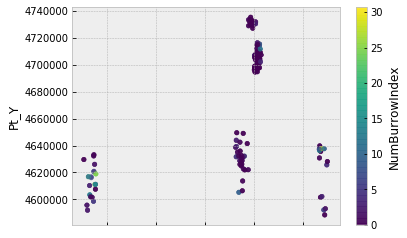

In [31]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
data.plot.scatter('Pt_X', 'Pt_Y', c='NumBurrowIndex', cmap=mpl.cm.viridis, alpha=0.75)

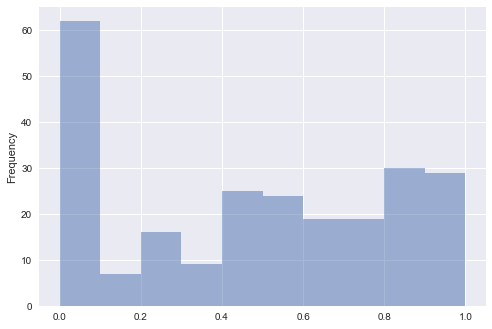

In [43]:
data['SageCov_gt_10'].plot.hist(alpha=0.5)

In [86]:

cats = pd.cut(data.Disturb_M2, bins=3, labels=['low', "medium", 'high'])
data_sub = data[['Disturb_M2', 'NumBurrowIndex', 'ShrbCov_gt13', 'SageCov_gt_10']]
data_sub['Disturbance Category'] = cats

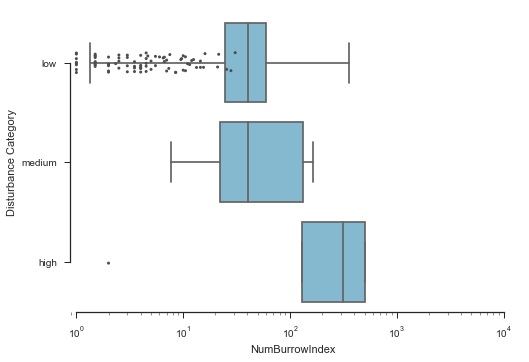

In [85]:
%matplotlib inline

import numpy as np
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)


# Plot the orbital period with horizontal boxes
ax = sns.boxplot(x="distance", y="method", data=planets,
                 whis=np.inf, color="c")

# Add in points to show each observation
sns.stripplot(x="NumBurrowIndex", y='Disturbance Category', data=data_sub,
              jitter=True, size=3, color=".3", linewidth=0)


# Make the quantitative axis logarithmic
ax.set_xscale("log")
sns.despine(trim=True)